In [1]:
import duckdb
import pyarrow.dataset as ds
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns;

In [2]:
dataset = ds.dataset("data/status", format="parquet", partitioning="hive")
con = duckdb.connect()
con = con.register("status", dataset)

## Mean values per stations

In [17]:
df_query = f"""select
        station_id,
        hour,
        num_bikes_available,
        num_bikes_disabled,
        num_docks_available,
        num_docks_disabled,
        status,
        make_timestamp(year, month, day, hour, minute, 0.0) as ts,
    from
        status
    where
        year::int = 2022
        AND month::int = 10 and
        status = 'IN_SERVICE'
"""
dataset_df = con.execute(df_query).df()

In [18]:
dataset_df["bikes_available"] = (dataset_df["num_bikes_available"]>0).astype(int)

In [19]:
station_means = dataset_df.groupby("station_id").mean()
pd.concat([station_means.min(), station_means.max(), station_means.mean(), station_means.std()],
          axis=1).set_axis(["min", "max", "mean", "std"], axis=1).round(3)

/tmp/ipykernel_19332/2658091689.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  station_means = dataset_df.groupby("station_id").mean()


,min,max,mean,std
hour,11.501,11.520,11.501,0.001
num_bikes_available,1.217,24.798,7.241,4.132
num_bikes_disabled,0.074,2.759,1.035,0.529
num_docks_available,1.173,25.907,9.689,4.885
num_docks_disabled,0.000,0.113,0.002,0.010
bikes_available,0.548,1.000,0.913,0.084


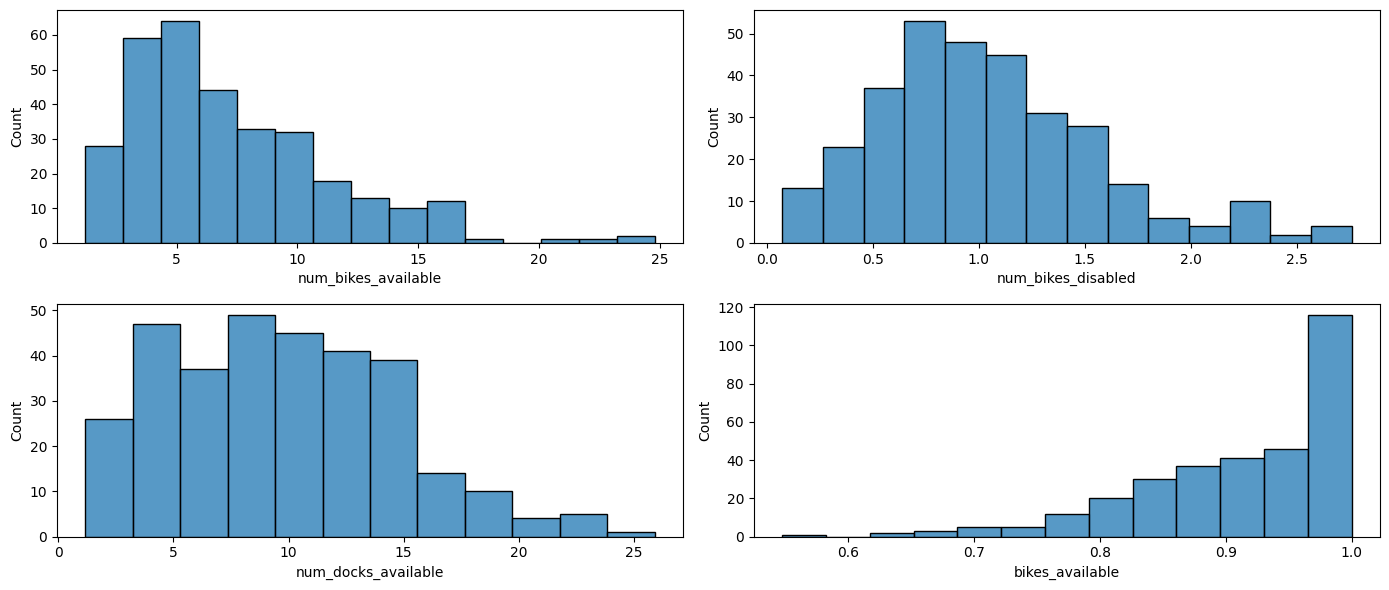

In [20]:
f, axs = plt.subplots(2, 2, figsize=(14, 6))
sns.histplot(station_means, x="num_bikes_available", ax=axs[0,0])
sns.histplot(station_means, x="num_bikes_disabled", ax=axs[0,1])
sns.histplot(station_means, x="num_docks_available", ax=axs[1,0])
sns.histplot(station_means, x="bikes_available", ax=axs[1,1])
f.tight_layout()

## Availability per hour

<AxesSubplot: xlabel='hour', ylabel='num_bikes_available'>

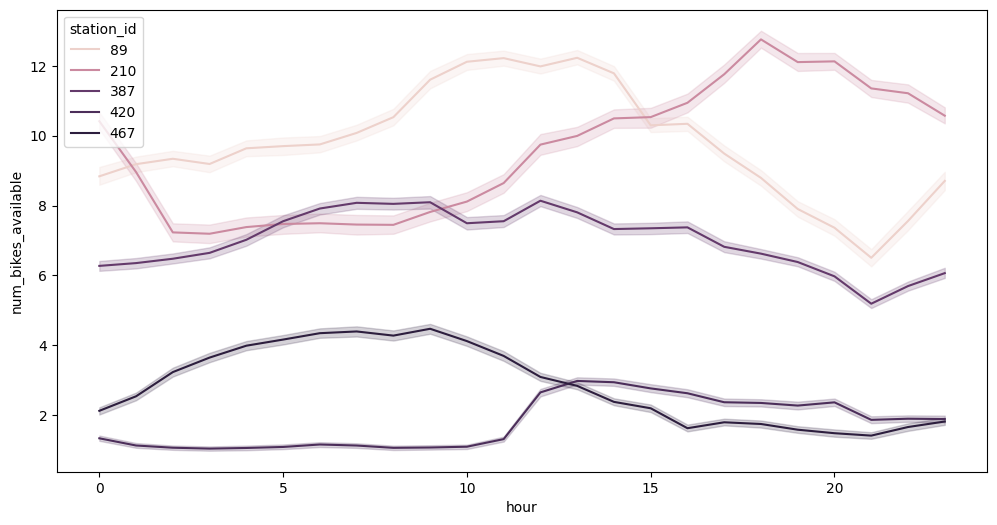

In [22]:
random.seed(73)
stations_to_plot = random.sample(list(dataset_df["station_id"].unique()), k=5)
plt.figure(figsize=(12,6))
sns.lineplot(dataset_df[dataset_df["station_id"].isin(stations_to_plot)], x="hour", y="num_bikes_available", hue="station_id")

## Empty stations percentage per hour

In [24]:
df_query = f"""select day::int as day, hour::int as hour, avg((num_bikes_available = 0)::int) * 100 as perc_empty
        FROM status
        WHERE year::int = 2022
        AND month::int = 10
        AND day::int >= 3
        AND day::int < 10
        AND status = 'IN_SERVICE'
        GROUP BY 1, 2
        ORDER BY 1 asc, 2 asc
"""
dataset_df = con.execute(df_query).df()

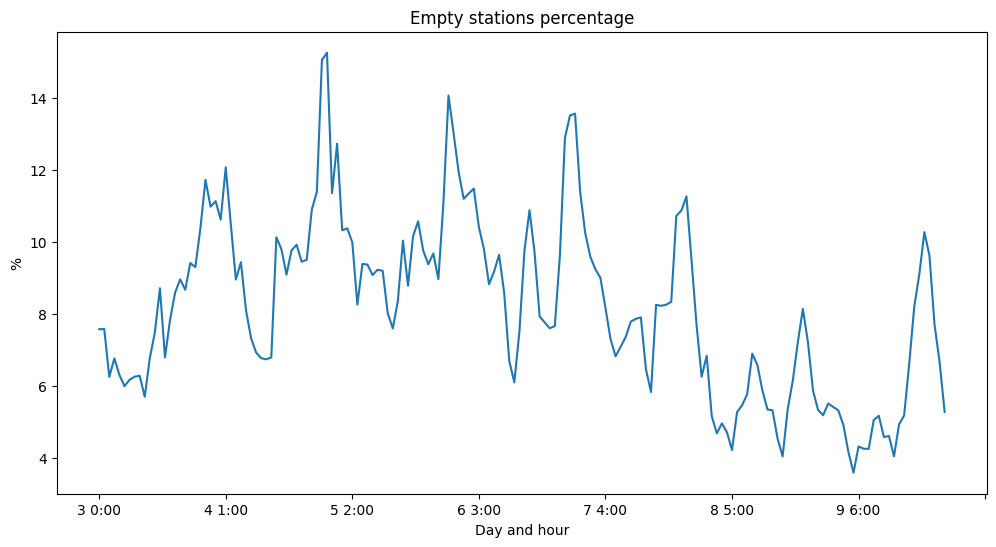

In [25]:
hist = dataset_df
hist["date"] = hist.apply(lambda x: f"{int(x.day)} {int(x.hour)}:00", axis=1)
hist.set_index("date", inplace=True)
plt.figure(figsize=(12,6))
hist.perc_empty.plot(kind="line")
plt.ylabel("%")
plt.xlabel("Day and hour")
plt.title("Empty stations percentage")
plt.show()

In [26]:
station_ids = con.execute("""select distinct(station_id) from status  WHERE year::int = 2022
        AND month::int = 10
        AND status = 'IN_SERVICE'""").df()["station_id"].values
len(station_ids)

318

In [27]:
random.seed(42)
df_query = f"""select day::int as day, hour::int as hour, station_id::string as station_id, avg((num_bikes_available = 0)::int) * 100 as perc_empty
        FROM status
        WHERE year::int = 2022
        AND month::int = 10
        AND status = 'IN_SERVICE'
        AND station_id IN ({",".join(str(rid) for rid in random.sample(list(station_ids), k=5))})
        AND day::int >= 3
        AND day::int < 10
        GROUP BY 1, 2, 3
        ORDER BY 1 asc, 2 asc
"""
dataset_df = con.execute(df_query).df()

/tmp/ipykernel_19332/3410374810.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(datelist)


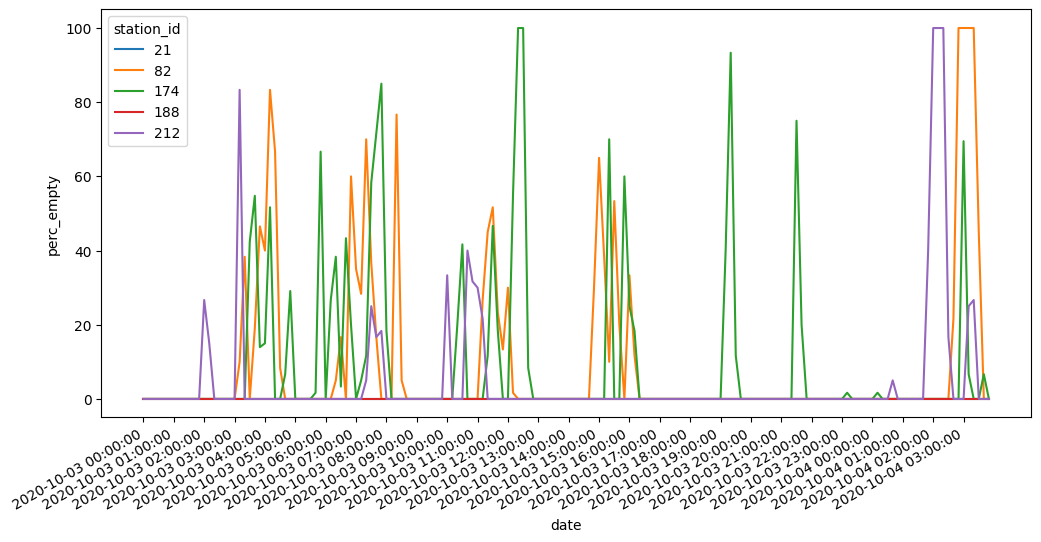

In [53]:
hist = dataset_df
hist["date"] = hist.apply(lambda x: f"2022-10-{int(x.day)} {int(x.hour)}:00", axis=1)
hist.set_index("date", inplace=True)
fig, ax = plt.subplots(figsize=(12,6))
datelist = pd.date_range(start='2020-10-03 00:00:00', end='2020-10-09 23:00:00',freq='1H').tolist()
sns.lineplot(hist, x="date", y="perc_empty", hue="station_id", ax=ax)
ax.set_xticklabels(datelist)
xtix = ax.get_xticks()
ax.set_xticks(xtix[::6])
fig.autofmt_xdate()